# Exercise 6: AR-GARCH models

**_Group: Ducray, Razanajatovo_**

Please find below our code and empirical work regarding Apple's price returns. To fit the AR+GARCH model, we will fit first the AR(p) model and then applying the GARCH model to the residuals. The final prediction will be the sum of the ARIMA forecast + the GARCH forecasts.

In [14]:
# Dataframe, maths and plotting libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm


from statsmodels.tsa.stattools import adfuller
from statsmodels import tsa
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

!pip install arch
from arch import arch_model

import warnings
warnings.filterwarnings("ignore")

In [15]:
#============== Load and prepare data ================

    # Import data
df = pd.read_excel('AAPL.xlsx',index_col=0)
    # Sort data in chronological order
df = df.sort_values(by='Date', ascending=True)
    # Compute the daily log returns on Apple stock prices
df_logret = np.log(df['Adj Close'].iloc[1:]).diff().dropna()*100
df_logret

Date
2018-01-04    0.463434
2018-01-05    1.132100
2018-01-08   -0.372141
2018-01-09   -0.011468
2018-01-10   -0.022950
                ...   
2022-12-15   -4.798752
2022-12-16   -1.468611
2022-12-19   -1.603751
2022-12-20   -0.052890
2022-12-21    2.353045
Name: Adj Close, Length: 1251, dtype: float64

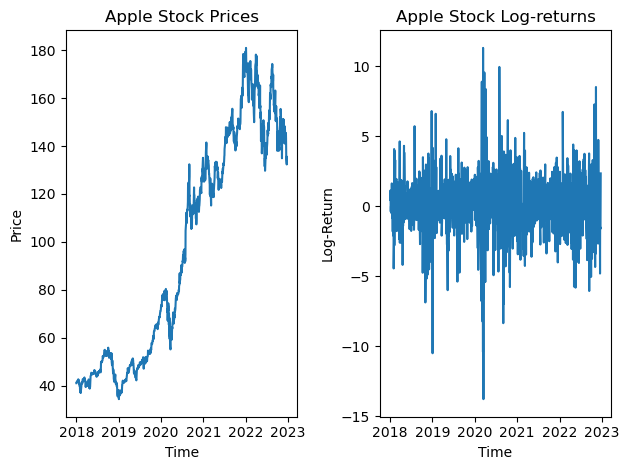

In [16]:
#================== Visual representation ===================

# Check the stock price's fluctuation
plt.subplot(1, 2, 1)
plt.plot(df['Adj Close'])
plt.title("Apple Stock Prices")
plt.xlabel('Time')
plt.ylabel('Price')
# Check the evolution of log-returns
plt.subplot(1, 2, 2)
plt.plot(df_logret)
plt.title("Apple Stock Log-returns")
plt.xlabel('Time')
plt.ylabel('Log-Return')
plt.tight_layout()

## 1. Checking the stationarity with the Augmented Dickey Fuller test

In [17]:
test = adfuller(df_logret)
df_adf = pd.DataFrame(index=['Test Statistic Value', "p-value", "Lags Used", "Number of Observations Used","Critical Value(1%)","Critical Value(5%)","Critical Value(10%)"],columns=['Output'])
df_adf['Output']['Test Statistic Value'] = test[0]
df_adf['Output']['p-value'] = test[1]
df_adf['Output']['Lags Used'] = test[2]
df_adf['Output']['Number of Observations Used'] = test[3]
df_adf['Output']['Critical Value(1%)'] = test[4]['1%']
df_adf['Output']['Critical Value(5%)'] = test[4]['5%']
df_adf['Output']['Critical Value(10%)'] = test[4]['10%']
df_adf

,Output
Test Statistic Value,-11.082035
p-value,0.0
Lags Used,8
Number of Observations Used,1242
Critical Value(1%),-3.435626
Critical Value(5%),-2.86387
Critical Value(10%),-2.56801


The null hypothesis is rejected: the process is **stationary** (pvalue below thresholds & t-stat < critical value)
No need to differentiate or detrend

## 2. Fitting AR and GARCH models

Splitting dataset in train (in-sample, i.e. from 01/01/2018 to 31/08/2022) and test(out-sample, i.e. from 01/09/2022 to 21/12/2022):

In [18]:
df_train = df_logret.loc['2018-01-04':'2022-08-31' ]
df_test = df_logret.loc['2022-09-01':'2022-12-21']

### Choosing the order for AR part:

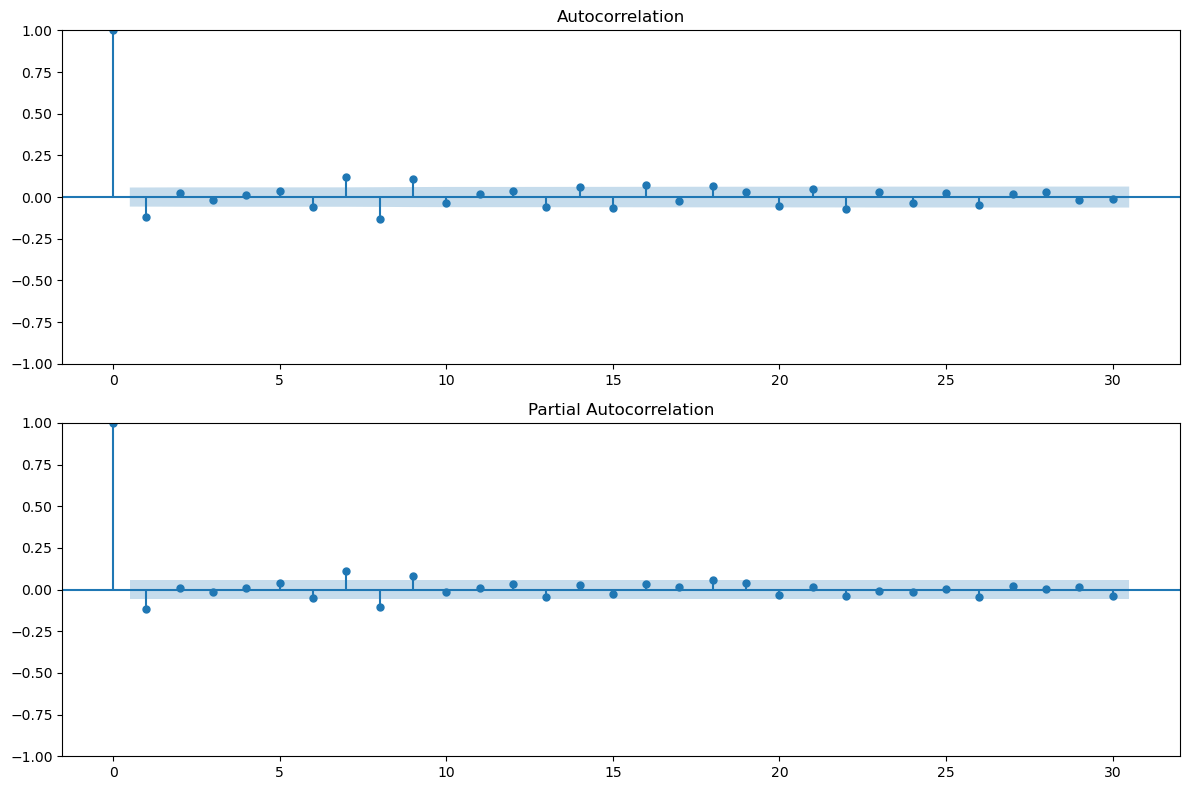

In [19]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_train, lags=30, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_train, lags=30, ax=ax2)
plt.tight_layout()

Graphically, we can't conclude about the exponential decay of the ACF but we can see a spike at order 1 on the PACF. We will use AIC and BIC criterion to confirm the optimal parameters:

**Paul: exponential decay or geometrical?**

In [20]:
from itertools import product
ar_order = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
ma_order = [0]
arma_res = [list(orders) for orders in product(ar_order, ma_order)]
#     pprint.pprint(arma_res)

for n in arma_res:
    print('fitting: ar:{} - ma:{}'.format(*n)) 
    try:
        arma_model  = tsa.arima.model.ARIMA(df_train, order= (n[0], 0, 0)).fit()
        n.extend([arma_model.aic / 1e3, arma_model.bic / 1e3])
    except Exception as exception:
        print(exception.__str__())
        n.extend([np.NaN, np.NaN])
    
res = pd.DataFrame(arma_res, columns = ['ar_order', 'ma_order', 'aic', 'bic'])
print('criterion\n', res)

fitting: ar:0 - ma:0
fitting: ar:1 - ma:0
fitting: ar:2 - ma:0
fitting: ar:3 - ma:0
fitting: ar:4 - ma:0
fitting: ar:5 - ma:0
fitting: ar:6 - ma:0
fitting: ar:7 - ma:0
fitting: ar:8 - ma:0
fitting: ar:9 - ma:0
fitting: ar:10 - ma:0
criterion
     ar_order  ma_order       aic       bic
0          0         0  5.053090  5.063224
1          1         0  5.038805  5.054007
2          2         0  5.040738  5.061007
3          3         0  5.042510  5.067846
4          4         0  5.044367  5.074771
5          5         0  5.044317  5.079789
6          6         0  5.043284  5.083823
7          7         0  5.030840  5.076446
8          8         0  5.020024  5.070697
9          9         0  5.014500  5.070241
10        10         0  5.016271  5.077079


In [21]:
#========= confirming order chosen ============
sm.tsa.arma_order_select_ic(df_train,max_ar=10,max_ma=0,ic='bic')['bic_min_order']

(1, 0)

**The order chosen is thus an AR(1) to fit the data**

### Detecting the GARCH effect:

First we construct the standardized residuals and run a normality test on them (Jarque-Bera test):

In [22]:
#===== Analyze for GARCH effects using the Jarque-Bera test on the standardized residuals =======================

# Compute standardized residuals
df_train_std = (df_train - np.mean(df_train))/ np.std(df_train)
nb_obs = len(df_train_std)

# Run the Jarque-Bera test on standardized residuals
jb = sm.stats.stattools.jarque_bera(df_train_std, axis=0)
df_jb = pd.DataFrame(index=['T-stat', "P-value", "Skewness", "Kurtosis"],columns=['Output'])
df_jb['Output']['T-stat'] = jb[0]
df_jb['Output']['P-value'] = jb[1]
df_jb['Output']['Skewness'] = jb[2]
df_jb['Output']['Kurtosis'] = jb[3]
print(df_jb)

# ON FAIT QUOI LAAAAAA ?????
mw_size = 250
jb_mw = np.zeros(nb_obs-mw_size)
for x in range(0, nb_obs-mw_size):
    jb =  sm.stats.stattools.jarque_bera(df_train_std[x:mw_size+x], axis=0)  
    jb_mw [x] = jb[1]
    
np.mean(jb_mw < 0.05)

               Output
T-stat    1252.198439
P-value           0.0
Skewness    -0.319214
Kurtosis     8.021239


0.8699891657638137

<div style="text-align: justify">The Jarque-Bera tests the model's goodness-of-fit and indicates on its distribution. Since the p-value is below the 1% threshold, we <strong> reject the null hypothesis</strong> of residuals' normal distribution. Therefore, we confirm the presence of a GARCH effect. One could use a different distribution for GARCH, one with fatter tails and that takes into account the skewness.</div>

Iteration:      1,   Func. Count:      7,   Neg. LLF: 6120.618619810915
Iteration:      2,   Func. Count:     17,   Neg. LLF: 53504.76858442735
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2603.476890726491
Iteration:      4,   Func. Count:     35,   Neg. LLF: 2575.4654742821367
Iteration:      5,   Func. Count:     43,   Neg. LLF: 2359.882528014747
Iteration:      6,   Func. Count:     50,   Neg. LLF: 2356.158847283118
Iteration:      7,   Func. Count:     56,   Neg. LLF: 2356.071056896617
Iteration:      8,   Func. Count:     62,   Neg. LLF: 2356.062944012455
Iteration:      9,   Func. Count:     68,   Neg. LLF: 2356.060876646876
Iteration:     10,   Func. Count:     74,   Neg. LLF: 2356.060535233218
Iteration:     11,   Func. Count:     80,   Neg. LLF: 2356.0604717099127
Iteration:     12,   Func. Count:     85,   Neg. LLF: 2356.060471709904
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2356.0604717099127
            Iterations: 1

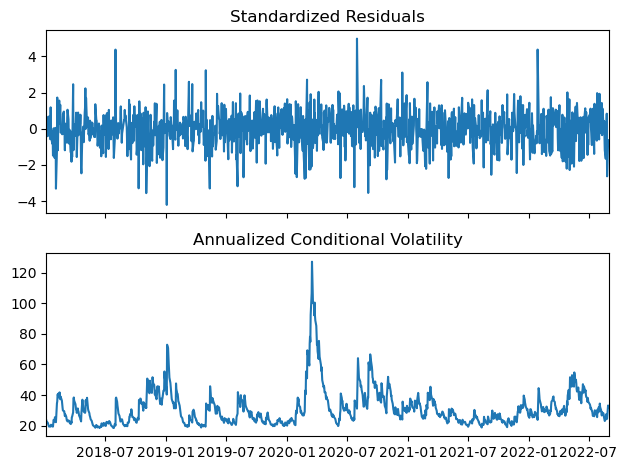

In [23]:
#===== GARCH(1,1) estimates =======================

arch = arch_model(df_train,p=1, o=0, q=1, mean='AR', lags=0, dist='t') 
res = arch.fit()
print(res.summary())
fig = res.plot(annualize='D')
fig.tight_layout()

Looking at this summary, we can conclude the presence of a GARCH(1,1).

**PAUL: Presence of GARCH(1,1) bc the param are signif diff from 0?**
I must review the course maybe but how do you identify or choose the params? Only using the AR(1) optimal param and the presence of GARCH effect ?

## 1-step ahead forecast:

In [24]:
idx = df_test.index
forecasts = []
data_shifted = df.shift(1).loc[idx].apply(np.log)

# estimate all
print('\nforecasting fixed')
arma_model  = tsa.arima.model.ARIMA(df_train, order=(1,0,0)).fit()
garch_res = arch_model(df_train_std,p=1, o=0, q=1, mean='AR', lags=0, dist='t').fit()

forecast_arma = arma_model.predict(n_periods=1)[0]

forecast_garch = garch_res.forecast(horizon=1, reindex=False)
predicted_et = forecast_garch.mean['h.1'].iloc[-1]

prediction = forecast_arma + predicted_et
prediction = pd.DataFrame(prediction, columns=['fixed'], index=idx).cumsum()


forecasting fixed
Iteration:      1,   Func. Count:      7,   Neg. LLF: 6988.224375263742
Iteration:      2,   Func. Count:     17,   Neg. LLF: 50688.788218607224
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2035.7967747452835
Iteration:      4,   Func. Count:     34,   Neg. LLF: 2907.450255764102
Iteration:      5,   Func. Count:     42,   Neg. LLF: 2613.0891693163844
Iteration:      6,   Func. Count:     49,   Neg. LLF: 1495.985268203405
Iteration:      7,   Func. Count:     55,   Neg. LLF: 1495.939629341462
Iteration:      8,   Func. Count:     61,   Neg. LLF: 1495.93267560625
Iteration:      9,   Func. Count:     67,   Neg. LLF: 1495.9308522110632
Iteration:     10,   Func. Count:     73,   Neg. LLF: 1495.9306202116882
Iteration:     11,   Func. Count:     79,   Neg. LLF: 1495.9305506424141
Iteration:     12,   Func. Count:     85,   Neg. LLF: 1495.9305500126916
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1495.9305500126916
  

In [25]:
# ============== recursive window =========================

print('forecasting recursive window')
forecast = []

for dt in df_test.index:
    _data = df_logret.loc[df_logret.index < dt]
    
    arma_model  = tsa.arima.model.ARIMA(_data, order=(1,0,0)).fit()
    garch_res = arch_model(_data,p=1, o=0, q=1, mean='AR', lags=0, dist='t').fit()
    
    forecast_arma = arma_model.predict(n_periods=1)[0]
    forecast_garch = garch_res.forecast(horizon=1, reindex=False)
    predicted_et = forecast_garch.mean['h.1'].iloc[-1]
    
    prediction = forecast_arma + predicted_et
    
    forecast.append(prediction.tolist())

forecast = pd.DataFrame(forecast, columns=['Recursive'], index=idx)
forecasts.append(forecast.add(data_shifted.squeeze(), axis=0))

forecasting recursive window
Iteration:      1,   Func. Count:      7,   Neg. LLF: 6120.618619810915
Iteration:      2,   Func. Count:     17,   Neg. LLF: 53504.76858442735
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2603.476890726491
Iteration:      4,   Func. Count:     35,   Neg. LLF: 2575.4654742821367
Iteration:      5,   Func. Count:     43,   Neg. LLF: 2359.882528014747
Iteration:      6,   Func. Count:     50,   Neg. LLF: 2356.158847283118
Iteration:      7,   Func. Count:     56,   Neg. LLF: 2356.071056896617
Iteration:      8,   Func. Count:     62,   Neg. LLF: 2356.062944012455
Iteration:      9,   Func. Count:     68,   Neg. LLF: 2356.060876646876
Iteration:     10,   Func. Count:     74,   Neg. LLF: 2356.060535233218
Iteration:     11,   Func. Count:     80,   Neg. LLF: 2356.0604717099127
Iteration:     12,   Func. Count:     85,   Neg. LLF: 2356.060471709904
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2356.0604717099

Iteration:      3,   Func. Count:     26,   Neg. LLF: 2618.72013056796
Iteration:      4,   Func. Count:     35,   Neg. LLF: 2592.127403681735
Iteration:      5,   Func. Count:     43,   Neg. LLF: 2411.24958167474
Iteration:      6,   Func. Count:     50,   Neg. LLF: 2378.054583386748
Iteration:      7,   Func. Count:     56,   Neg. LLF: 2377.855042013029
Iteration:      8,   Func. Count:     62,   Neg. LLF: 2377.829364778261
Iteration:      9,   Func. Count:     68,   Neg. LLF: 2377.8245000368793
Iteration:     10,   Func. Count:     74,   Neg. LLF: 2377.8237366121284
Iteration:     11,   Func. Count:     80,   Neg. LLF: 2377.8234334641243
Iteration:     12,   Func. Count:     85,   Neg. LLF: 2377.8234334641265
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2377.8234334641243
            Iterations: 12
            Function evaluations: 85
            Gradient evaluations: 12
Iteration:      1,   Func. Count:      7,   Neg. LLF: 6206.721826104

Iteration:      1,   Func. Count:      7,   Neg. LLF: 6242.3142258467815
Iteration:      2,   Func. Count:     17,   Neg. LLF: 53612.31732509449
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2638.2713224743447
Iteration:      4,   Func. Count:     35,   Neg. LLF: 2611.251204168425
Iteration:      5,   Func. Count:     43,   Neg. LLF: 2448.5868604725415
Iteration:      6,   Func. Count:     50,   Neg. LLF: 2394.0858988836953
Iteration:      7,   Func. Count:     56,   Neg. LLF: 2393.90403991599
Iteration:      8,   Func. Count:     62,   Neg. LLF: 2393.8832135359953
Iteration:      9,   Func. Count:     68,   Neg. LLF: 2393.879297123193
Iteration:     10,   Func. Count:     74,   Neg. LLF: 2393.8786702704856
Iteration:     11,   Func. Count:     80,   Neg. LLF: 2393.878427884586
Iteration:     12,   Func. Count:     85,   Neg. LLF: 2393.8784278845887
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2393.878427884586
            Iterations

Iteration:      1,   Func. Count:      7,   Neg. LLF: 6320.234657139125
Iteration:      2,   Func. Count:     17,   Neg. LLF: 53815.47221584899
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2664.6721487111736
Iteration:      4,   Func. Count:     35,   Neg. LLF: 2628.2171092795606
Iteration:      5,   Func. Count:     43,   Neg. LLF: 2624.284675552267
Iteration:      6,   Func. Count:     50,   Neg. LLF: 2414.0299470856107
Iteration:      7,   Func. Count:     56,   Neg. LLF: 2413.8396630123534
Iteration:      8,   Func. Count:     62,   Neg. LLF: 2413.8185887595137
Iteration:      9,   Func. Count:     68,   Neg. LLF: 2413.8144255607813
Iteration:     10,   Func. Count:     74,   Neg. LLF: 2413.8137867326495
Iteration:     11,   Func. Count:     80,   Neg. LLF: 2413.8135738758156
Iteration:     12,   Func. Count:     85,   Neg. LLF: 2413.8135738758156
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2413.8135738758156
            Iterat

Iteration:      1,   Func. Count:      7,   Neg. LLF: 6384.271969856934
Iteration:      2,   Func. Count:     17,   Neg. LLF: 55136.389999758365
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2691.3157886156087
Iteration:      4,   Func. Count:     35,   Neg. LLF: 2657.144916646418
Iteration:      5,   Func. Count:     43,   Neg. LLF: 2486.798461224477
Iteration:      6,   Func. Count:     50,   Neg. LLF: 2439.0610559846928
Iteration:      7,   Func. Count:     56,   Neg. LLF: 2438.859758881758
Iteration:      8,   Func. Count:     62,   Neg. LLF: 2438.835240285334
Iteration:      9,   Func. Count:     68,   Neg. LLF: 2438.83092664413
Iteration:     10,   Func. Count:     74,   Neg. LLF: 2438.830337184328
Iteration:     11,   Func. Count:     80,   Neg. LLF: 2438.830129216183
Iteration:     12,   Func. Count:     85,   Neg. LLF: 2438.8301292161855
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2438.830129216183
            Iterations: 1

Iteration:     11,   Func. Count:     79,   Neg. LLF: 2458.6422875328603
Iteration:     12,   Func. Count:     85,   Neg. LLF: 2458.6422869023727
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2458.6422869023727
            Iterations: 12
            Function evaluations: 85
            Gradient evaluations: 12
Iteration:      1,   Func. Count:      7,   Neg. LLF: 6429.071502072134
Iteration:      2,   Func. Count:     17,   Neg. LLF: 55971.37281655866
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2715.9021011616064
Iteration:      4,   Func. Count:     34,   Neg. LLF: 2678.6392146404633
Iteration:      5,   Func. Count:     42,   Neg. LLF: 3629.578439363765
Iteration:      6,   Func. Count:     49,   Neg. LLF: 2461.9261310109036
Iteration:      7,   Func. Count:     55,   Neg. LLF: 2461.811530668352
Iteration:      8,   Func. Count:     61,   Neg. LLF: 2461.797084207637
Iteration:      9,   Func. Count:     67,   Neg. LLF: 2461.794208

Iteration:     10,   Func. Count:     73,   Neg. LLF: 2486.2920835164014
Iteration:     11,   Func. Count:     79,   Neg. LLF: 2486.291847504606
Iteration:     12,   Func. Count:     85,   Neg. LLF: 2486.2918468743637
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2486.2918468743637
            Iterations: 12
            Function evaluations: 85
            Gradient evaluations: 12
Iteration:      1,   Func. Count:      7,   Neg. LLF: 6464.978106155534
Iteration:      2,   Func. Count:     17,   Neg. LLF: 55324.24817539286
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2741.603570355261
Iteration:      4,   Func. Count:     34,   Neg. LLF: 2705.5505204498577
Iteration:      5,   Func. Count:     42,   Neg. LLF: 3636.687537409417
Iteration:      6,   Func. Count:     49,   Neg. LLF: 2488.525949698256
Iteration:      7,   Func. Count:     55,   Neg. LLF: 2488.33149793431
Iteration:      8,   Func. Count:     61,   Neg. LLF: 2488.305715442

Iteration:      5,   Func. Count:     42,   Neg. LLF: 3666.1102526517643
Iteration:      6,   Func. Count:     49,   Neg. LLF: 2511.363188975822
Iteration:      7,   Func. Count:     55,   Neg. LLF: 2511.187603586326
Iteration:      8,   Func. Count:     61,   Neg. LLF: 2511.1647082775216
Iteration:      9,   Func. Count:     67,   Neg. LLF: 2511.16028023292
Iteration:     10,   Func. Count:     73,   Neg. LLF: 2511.1596447038946
Iteration:     11,   Func. Count:     79,   Neg. LLF: 2511.1594577088485
Iteration:     12,   Func. Count:     85,   Neg. LLF: 2511.159457124192
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2511.159457124192
            Iterations: 12
            Function evaluations: 85
            Gradient evaluations: 12
Iteration:      1,   Func. Count:      7,   Neg. LLF: 6530.446600982192
Iteration:      2,   Func. Count:     17,   Neg. LLF: 55630.058195174446
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2774.77631115

Iteration:     11,   Func. Count:     79,   Neg. LLF: 2533.0793943751787
Iteration:     12,   Func. Count:     85,   Neg. LLF: 2533.0793937938506
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2533.0793937938506
            Iterations: 12
            Function evaluations: 85
            Gradient evaluations: 12
Iteration:      1,   Func. Count:      7,   Neg. LLF: 6632.149587560365
Iteration:      2,   Func. Count:     17,   Neg. LLF: 54909.675106350085
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2807.9125793775092
Iteration:      4,   Func. Count:     34,   Neg. LLF: 2756.226346896214
Iteration:      5,   Func. Count:     42,   Neg. LLF: 3712.16945325872
Iteration:      6,   Func. Count:     49,   Neg. LLF: 2535.395636739123
Iteration:      7,   Func. Count:     55,   Neg. LLF: 2535.156511015596
Iteration:      8,   Func. Count:     61,   Neg. LLF: 2535.1251241839495
Iteration:      9,   Func. Count:     67,   Neg. LLF: 2535.1189729

In [26]:
# =================== rolling window ==================================== 
print('forecasting rolling window\n')
forecast = []
roll_freq = 200
    
for dt in df_test.index:
    _data = df_logret.loc[df_logret.index < dt]
    arma_model  = tsa.arima.model.ARIMA(_data.iloc[-roll_freq:], order=(1,0,0)).fit()
    garch_res = arch_model(_data,p=1, o=0, q=1, mean='AR', lags=0, dist='t').fit()
    
    forecast_arma = arma_model.predict(n_periods=1)[0]
    forecast_garch = garch_res.forecast(horizon=1, reindex=False)
    predicted_et = forecast_garch.mean['h.1'].iloc[-1]
    
    prediction = forecast_arma + predicted_et
    
    forecast.append(prediction.tolist())
    
forecast = pd.DataFrame(forecast, columns=['Rolling'], index=idx)
forecasts.append(forecast.add(data_shifted.squeeze(), axis=0))

forecasting rolling window

Iteration:      1,   Func. Count:      7,   Neg. LLF: 6120.618619810915
Iteration:      2,   Func. Count:     17,   Neg. LLF: 53504.76858442735
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2603.476890726491
Iteration:      4,   Func. Count:     35,   Neg. LLF: 2575.4654742821367
Iteration:      5,   Func. Count:     43,   Neg. LLF: 2359.882528014747
Iteration:      6,   Func. Count:     50,   Neg. LLF: 2356.158847283118
Iteration:      7,   Func. Count:     56,   Neg. LLF: 2356.071056896617
Iteration:      8,   Func. Count:     62,   Neg. LLF: 2356.062944012455
Iteration:      9,   Func. Count:     68,   Neg. LLF: 2356.060876646876
Iteration:     10,   Func. Count:     74,   Neg. LLF: 2356.060535233218
Iteration:     11,   Func. Count:     80,   Neg. LLF: 2356.0604717099127
Iteration:     12,   Func. Count:     85,   Neg. LLF: 2356.060471709904
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2356.06047170991

Iteration:      1,   Func. Count:      7,   Neg. LLF: 6209.644931776456
Iteration:      2,   Func. Count:     17,   Neg. LLF: 53907.595702549734
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2626.372559975114
Iteration:      4,   Func. Count:     35,   Neg. LLF: 2602.7983352343645
Iteration:      5,   Func. Count:     43,   Neg. LLF: 2419.1036995957074
Iteration:      6,   Func. Count:     50,   Neg. LLF: 2386.494502970504
Iteration:      7,   Func. Count:     56,   Neg. LLF: 2386.301523314461
Iteration:      8,   Func. Count:     62,   Neg. LLF: 2386.2774036068176
Iteration:      9,   Func. Count:     68,   Neg. LLF: 2386.272886895993
Iteration:     10,   Func. Count:     74,   Neg. LLF: 2386.2721906328793
Iteration:     11,   Func. Count:     80,   Neg. LLF: 2386.2719187402
Iteration:     12,   Func. Count:     85,   Neg. LLF: 2386.2719187402017
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2386.2719187402
            Iterations: 12

Iteration:      1,   Func. Count:      7,   Neg. LLF: 6351.039661467841
Iteration:      2,   Func. Count:     17,   Neg. LLF: 52736.15436595081
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2675.914148203426
Iteration:      4,   Func. Count:     34,   Neg. LLF: 2633.9814731055126
Iteration:      5,   Func. Count:     42,   Neg. LLF: 3560.124554915626
Iteration:      6,   Func. Count:     49,   Neg. LLF: 2419.2013908517897
Iteration:      7,   Func. Count:     55,   Neg. LLF: 2419.0726676764816
Iteration:      8,   Func. Count:     61,   Neg. LLF: 2419.053994125603
Iteration:      9,   Func. Count:     67,   Neg. LLF: 2419.050869047438
Iteration:     10,   Func. Count:     73,   Neg. LLF: 2419.050194368572
Iteration:     11,   Func. Count:     79,   Neg. LLF: 2419.0500057139557
Iteration:     12,   Func. Count:     85,   Neg. LLF: 2419.05000498625
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2419.05000498625
            Iterations: 12

Iteration:      1,   Func. Count:      7,   Neg. LLF: 6361.241738797939
Iteration:      2,   Func. Count:     17,   Neg. LLF: 56355.08233092746
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2697.344324986884
Iteration:      4,   Func. Count:     35,   Neg. LLF: 2671.390842263247
Iteration:      5,   Func. Count:     43,   Neg. LLF: 2553.2851168775705
Iteration:      6,   Func. Count:     50,   Neg. LLF: 2454.4266152361397
Iteration:      7,   Func. Count:     56,   Neg. LLF: 2454.2443313899603
Iteration:      8,   Func. Count:     62,   Neg. LLF: 2454.222139505009
Iteration:      9,   Func. Count:     68,   Neg. LLF: 2454.2172132301193
Iteration:     10,   Func. Count:     74,   Neg. LLF: 2454.21645980761
Iteration:     11,   Func. Count:     80,   Neg. LLF: 2454.2162530099827
Iteration:     12,   Func. Count:     85,   Neg. LLF: 2454.216253009983
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2454.2162530099827
            Iterations:

Iteration:      1,   Func. Count:      7,   Neg. LLF: 6464.978106155534
Iteration:      2,   Func. Count:     17,   Neg. LLF: 55324.24817539286
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2741.603570355261
Iteration:      4,   Func. Count:     34,   Neg. LLF: 2705.5505204498577
Iteration:      5,   Func. Count:     42,   Neg. LLF: 3636.687537409417
Iteration:      6,   Func. Count:     49,   Neg. LLF: 2488.525949698256
Iteration:      7,   Func. Count:     55,   Neg. LLF: 2488.33149793431
Iteration:      8,   Func. Count:     61,   Neg. LLF: 2488.3057154426224
Iteration:      9,   Func. Count:     67,   Neg. LLF: 2488.30022770726
Iteration:     10,   Func. Count:     73,   Neg. LLF: 2488.2994243110725
Iteration:     11,   Func. Count:     79,   Neg. LLF: 2488.2991728981688
Iteration:     12,   Func. Count:     85,   Neg. LLF: 2488.2991721629614
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2488.2991721629614
            Iterations: 

Iteration:     12,   Func. Count:     84,   Neg. LLF: 2517.3502129740855
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2517.350212974082
            Iterations: 12
            Function evaluations: 84
            Gradient evaluations: 12
Iteration:      1,   Func. Count:      7,   Neg. LLF: 6565.3654312669605
Iteration:      2,   Func. Count:     17,   Neg. LLF: 55617.18547246149
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2789.777377901315
Iteration:      4,   Func. Count:     34,   Neg. LLF: 2735.1870655085554
Iteration:      5,   Func. Count:     42,   Neg. LLF: 3679.056593692683
Iteration:      6,   Func. Count:     49,   Neg. LLF: 2519.5268644787016
Iteration:      7,   Func. Count:     55,   Neg. LLF: 2519.3588237662566
Iteration:      8,   Func. Count:     61,   Neg. LLF: 2519.3372037979275
Iteration:      9,   Func. Count:     67,   Neg. LLF: 2519.333347529485
Iteration:     10,   Func. Count:     73,   Neg. LLF: 2519.332793

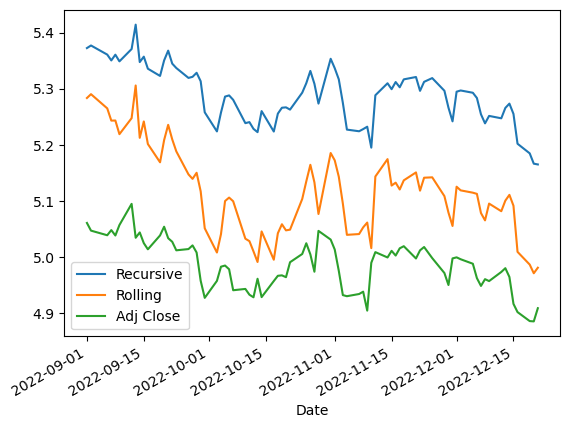


 forecasts 
             Recursive   Rolling
Date                           
2022-09-01   5.372622  5.283546
2022-09-02   5.377236  5.290395
2022-09-06   5.361007  5.265074
2022-09-07   5.350605  5.243247
2022-09-08   5.360835  5.243408
...               ...       ...
2022-12-15   5.255184  5.091391
2022-12-16   5.201973  5.009125
2022-12-19   5.184822  4.986387
2022-12-20   5.166414  4.970939
2022-12-21   5.165025  4.980808

[78 rows x 2 columns]

 MAE 
 Recursive    2.362447
Rolling      1.021278
dtype: float64

 RMSE 
 Recursive    0.849381
Rolling      0.390131
dtype: float64


In [27]:
#=================== plot forecasts and calc error ===========================================================================    
    
forecasts = pd.concat(forecasts, axis=1)
obs = df.loc[df_test.index].apply(np.log)
# plot data and forcasts
output = pd.concat([forecasts, obs], axis=1)
output.plot()
plt.show()
# plot data and forcasts
epsilon = forecasts.sub(obs.squeeze(), axis=0)
    
mae = epsilon.abs().sum(axis=0)/10
rmse = ((epsilon**2).sum(axis=0)/10)**.5
    
print('\n forecasts \n', forecasts)
print('\n MAE \n', mae) 
print('\n RMSE \n', rmse) 

## 20-steps ahead forecast:

In [31]:
idx = df_test.index
forecasts = []
data_shifted = df.shift(20).loc[idx].apply(np.log)

# estimate all
print('\nforecasting fixed')
arma_model  = tsa.arima.model.ARIMA(df_train, order=(1,0,0)).fit()
garch_res = arch_model(df_train_std,p=1, o=0, q=1, mean='AR', lags=0, dist='t').fit()

forecast_arma = arma_model.predict(n_periods=20)[0]

forecast_garch = garch_res.forecast(horizon=20, reindex=False)
predicted_et = forecast_garch.mean['h.20'].iloc[-1]

prediction = forecast_arma + predicted_et
prediction = pd.DataFrame(prediction, columns=['Fixed'], index=idx).cumsum()


forecasting fixed
Iteration:      1,   Func. Count:      7,   Neg. LLF: 6988.224375263742
Iteration:      2,   Func. Count:     17,   Neg. LLF: 50688.788218607224
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2035.7967747452835
Iteration:      4,   Func. Count:     34,   Neg. LLF: 2907.450255764102
Iteration:      5,   Func. Count:     42,   Neg. LLF: 2613.0891693163844
Iteration:      6,   Func. Count:     49,   Neg. LLF: 1495.985268203405
Iteration:      7,   Func. Count:     55,   Neg. LLF: 1495.939629341462
Iteration:      8,   Func. Count:     61,   Neg. LLF: 1495.93267560625
Iteration:      9,   Func. Count:     67,   Neg. LLF: 1495.9308522110632
Iteration:     10,   Func. Count:     73,   Neg. LLF: 1495.9306202116882
Iteration:     11,   Func. Count:     79,   Neg. LLF: 1495.9305506424141
Iteration:     12,   Func. Count:     85,   Neg. LLF: 1495.9305500126916
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1495.9305500126916
  

In [32]:
# ============== recursive window ========================= 
print('forecasting recursive window')
forecast = []

for dt in df_test.index:
    _data = df_logret.loc[df_logret.index < dt]
    
    arma_model  = tsa.arima.model.ARIMA(_data, order=(1,0,0)).fit()
    garch_res = arch_model(_data,p=1, o=0, q=1, mean='AR', lags=0, dist='t').fit()
    
    forecast_arma = arma_model.predict(n_periods=20)[0]
    forecast_garch = garch_res.forecast(horizon=20, reindex=False)
    predicted_et = forecast_garch.mean['h.20'].iloc[-1]
    
    prediction = forecast_arma + predicted_et
    
    forecast.append(prediction.tolist())

forecast = pd.DataFrame(forecast, columns=['Recursive'], index=idx)
forecasts.append(forecast.add(data_shifted.squeeze(), axis=0))

forecasting recursive window
Iteration:      1,   Func. Count:      7,   Neg. LLF: 6120.618619810915
Iteration:      2,   Func. Count:     17,   Neg. LLF: 53504.76858442735
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2603.476890726491
Iteration:      4,   Func. Count:     35,   Neg. LLF: 2575.4654742821367
Iteration:      5,   Func. Count:     43,   Neg. LLF: 2359.882528014747
Iteration:      6,   Func. Count:     50,   Neg. LLF: 2356.158847283118
Iteration:      7,   Func. Count:     56,   Neg. LLF: 2356.071056896617
Iteration:      8,   Func. Count:     62,   Neg. LLF: 2356.062944012455
Iteration:      9,   Func. Count:     68,   Neg. LLF: 2356.060876646876
Iteration:     10,   Func. Count:     74,   Neg. LLF: 2356.060535233218
Iteration:     11,   Func. Count:     80,   Neg. LLF: 2356.0604717099127
Iteration:     12,   Func. Count:     85,   Neg. LLF: 2356.060471709904
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2356.0604717099

Iteration:      1,   Func. Count:      7,   Neg. LLF: 6191.286644266087
Iteration:      2,   Func. Count:     17,   Neg. LLF: 53611.82003391755
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2618.72013056796
Iteration:      4,   Func. Count:     35,   Neg. LLF: 2592.127403681735
Iteration:      5,   Func. Count:     43,   Neg. LLF: 2411.24958167474
Iteration:      6,   Func. Count:     50,   Neg. LLF: 2378.054583386748
Iteration:      7,   Func. Count:     56,   Neg. LLF: 2377.855042013029
Iteration:      8,   Func. Count:     62,   Neg. LLF: 2377.829364778261
Iteration:      9,   Func. Count:     68,   Neg. LLF: 2377.8245000368793
Iteration:     10,   Func. Count:     74,   Neg. LLF: 2377.8237366121284
Iteration:     11,   Func. Count:     80,   Neg. LLF: 2377.8234334641243
Iteration:     12,   Func. Count:     85,   Neg. LLF: 2377.8234334641265
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2377.8234334641243
            Iterations: 1

Iteration:     12,   Func. Count:     85,   Neg. LLF: 2392.3692579068374
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2392.3692579068347
            Iterations: 12
            Function evaluations: 85
            Gradient evaluations: 12
Iteration:      1,   Func. Count:      7,   Neg. LLF: 6242.3142258467815
Iteration:      2,   Func. Count:     17,   Neg. LLF: 53612.31732509449
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2638.2713224743447
Iteration:      4,   Func. Count:     35,   Neg. LLF: 2611.251204168425
Iteration:      5,   Func. Count:     43,   Neg. LLF: 2448.5868604725415
Iteration:      6,   Func. Count:     50,   Neg. LLF: 2394.0858988836953
Iteration:      7,   Func. Count:     56,   Neg. LLF: 2393.90403991599
Iteration:      8,   Func. Count:     62,   Neg. LLF: 2393.8832135359953
Iteration:      9,   Func. Count:     68,   Neg. LLF: 2393.879297123193
Iteration:     10,   Func. Count:     74,   Neg. LLF: 2393.878670

Iteration:      1,   Func. Count:      7,   Neg. LLF: 6358.548312682527
Iteration:      2,   Func. Count:     17,   Neg. LLF: 53761.75076712967
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2678.7036598993022
Iteration:      4,   Func. Count:     34,   Neg. LLF: 2635.40988836647
Iteration:      5,   Func. Count:     42,   Neg. LLF: 3562.171103782436
Iteration:      6,   Func. Count:     49,   Neg. LLF: 2421.0479376499
Iteration:      7,   Func. Count:     55,   Neg. LLF: 2420.9191648444103
Iteration:      8,   Func. Count:     61,   Neg. LLF: 2420.9003769413516
Iteration:      9,   Func. Count:     67,   Neg. LLF: 2420.897290920866
Iteration:     10,   Func. Count:     73,   Neg. LLF: 2420.89662331997
Iteration:     11,   Func. Count:     79,   Neg. LLF: 2420.8964345490613
Iteration:     12,   Func. Count:     85,   Neg. LLF: 2420.896433845278
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2420.896433845278
            Iterations: 12
 

Iteration:      1,   Func. Count:      7,   Neg. LLF: 6384.271969856934
Iteration:      2,   Func. Count:     17,   Neg. LLF: 55136.389999758365
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2691.3157886156087
Iteration:      4,   Func. Count:     35,   Neg. LLF: 2657.144916646418
Iteration:      5,   Func. Count:     43,   Neg. LLF: 2486.798461224477
Iteration:      6,   Func. Count:     50,   Neg. LLF: 2439.0610559846928
Iteration:      7,   Func. Count:     56,   Neg. LLF: 2438.859758881758
Iteration:      8,   Func. Count:     62,   Neg. LLF: 2438.835240285334
Iteration:      9,   Func. Count:     68,   Neg. LLF: 2438.83092664413
Iteration:     10,   Func. Count:     74,   Neg. LLF: 2438.830337184328
Iteration:     11,   Func. Count:     80,   Neg. LLF: 2438.830129216183
Iteration:     12,   Func. Count:     85,   Neg. LLF: 2438.8301292161855
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2438.830129216183
            Iterations: 1

Iteration:      1,   Func. Count:      7,   Neg. LLF: 6473.193695533144
Iteration:      2,   Func. Count:     17,   Neg. LLF: 55762.951091951836
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2728.117655036079
Iteration:      4,   Func. Count:     34,   Neg. LLF: 2682.7138387956866
Iteration:      5,   Func. Count:     42,   Neg. LLF: 3189.0562180889738
Iteration:      6,   Func. Count:     49,   Neg. LLF: 2467.276768533105
Iteration:      7,   Func. Count:     55,   Neg. LLF: 2467.1572583409643
Iteration:      8,   Func. Count:     61,   Neg. LLF: 2467.1433550305414
Iteration:      9,   Func. Count:     67,   Neg. LLF: 2467.1407359965724
Iteration:     10,   Func. Count:     73,   Neg. LLF: 2467.140252221036
Iteration:     11,   Func. Count:     79,   Neg. LLF: 2467.140140018866
Iteration:     12,   Func. Count:     84,   Neg. LLF: 2467.1401400188633
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2467.140140018866
            Iteration

Iteration:     12,   Func. Count:     85,   Neg. LLF: 2490.2608805316777
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2490.2608805316777
            Iterations: 12
            Function evaluations: 85
            Gradient evaluations: 12
Iteration:      1,   Func. Count:      7,   Neg. LLF: 6469.2954944443245
Iteration:      2,   Func. Count:     17,   Neg. LLF: 55007.10920434104
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2743.723759054069
Iteration:      4,   Func. Count:     34,   Neg. LLF: 2707.4364943982505
Iteration:      5,   Func. Count:     42,   Neg. LLF: 3636.3418053454434
Iteration:      6,   Func. Count:     49,   Neg. LLF: 2492.2671449095733
Iteration:      7,   Func. Count:     55,   Neg. LLF: 2492.0732557448637
Iteration:      8,   Func. Count:     61,   Neg. LLF: 2492.045117781277
Iteration:      9,   Func. Count:     67,   Neg. LLF: 2492.0391869569144
Iteration:     10,   Func. Count:     73,   Neg. LLF: 2492.0382

Iteration:      7,   Func. Count:     55,   Neg. LLF: 2514.675680865143
Iteration:      8,   Func. Count:     61,   Neg. LLF: 2514.6505164294044
Iteration:      9,   Func. Count:     67,   Neg. LLF: 2514.645830625609
Iteration:     10,   Func. Count:     73,   Neg. LLF: 2514.6451248395842
Iteration:     11,   Func. Count:     79,   Neg. LLF: 2514.64490617568
Iteration:     12,   Func. Count:     85,   Neg. LLF: 2514.6449054812533
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2514.6449054812533
            Iterations: 12
            Function evaluations: 85
            Gradient evaluations: 12
Iteration:      1,   Func. Count:      7,   Neg. LLF: 6555.700637091807
Iteration:      2,   Func. Count:     17,   Neg. LLF: 55673.836822995174
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2785.016687881311
Iteration:      4,   Func. Count:     34,   Neg. LLF: 2733.409127230748
Iteration:      5,   Func. Count:     42,   Neg. LLF: 3675.56673971

Iteration:      7,   Func. Count:     55,   Neg. LLF: 2537.2462935615913
Iteration:      8,   Func. Count:     61,   Neg. LLF: 2537.2162079744235
Iteration:      9,   Func. Count:     67,   Neg. LLF: 2537.21044997428
Iteration:     10,   Func. Count:     73,   Neg. LLF: 2537.2097565442623
Iteration:     11,   Func. Count:     79,   Neg. LLF: 2537.209541124311
Iteration:     12,   Func. Count:     84,   Neg. LLF: 2537.2095411243154
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2537.209541124311
            Iterations: 12
            Function evaluations: 84
            Gradient evaluations: 12
Iteration:      1,   Func. Count:      7,   Neg. LLF: 6644.0139776852775
Iteration:      2,   Func. Count:     17,   Neg. LLF: 55163.97810777546
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2814.576268173345
Iteration:      4,   Func. Count:     34,   Neg. LLF: 2760.3606590740064
Iteration:      5,   Func. Count:     42,   Neg. LLF: 3713.6992366

In [33]:
# =================== rolling window ==================================== 
print('forecasting rolling window\n')
forecast = []
roll_freq = 200
    
for dt in df_test.index:
    _data = df_logret.loc[df_logret.index < dt]
    arma_model  = tsa.arima.model.ARIMA(_data.iloc[-roll_freq:], order=(1,0,0)).fit()
    garch_res = arch_model(_data,p=1, o=0, q=1, mean='AR', lags=0, dist='t').fit()
    
    forecast_arma = arma_model.predict(n_periods=20)[0]
    forecast_garch = garch_res.forecast(horizon=20, reindex=False)
    predicted_et = forecast_garch.mean['h.20'].iloc[-1]
    
    prediction = forecast_arma + predicted_et
    
    forecast.append(prediction.tolist())
    
forecast = pd.DataFrame(forecast, columns=['Rolling'], index=idx)
forecasts.append(forecast.add(data_shifted.squeeze(), axis=0))

forecasting rolling window

Iteration:      1,   Func. Count:      7,   Neg. LLF: 6120.618619810915
Iteration:      2,   Func. Count:     17,   Neg. LLF: 53504.76858442735
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2603.476890726491
Iteration:      4,   Func. Count:     35,   Neg. LLF: 2575.4654742821367
Iteration:      5,   Func. Count:     43,   Neg. LLF: 2359.882528014747
Iteration:      6,   Func. Count:     50,   Neg. LLF: 2356.158847283118
Iteration:      7,   Func. Count:     56,   Neg. LLF: 2356.071056896617
Iteration:      8,   Func. Count:     62,   Neg. LLF: 2356.062944012455
Iteration:      9,   Func. Count:     68,   Neg. LLF: 2356.060876646876
Iteration:     10,   Func. Count:     74,   Neg. LLF: 2356.060535233218
Iteration:     11,   Func. Count:     80,   Neg. LLF: 2356.0604717099127
Iteration:     12,   Func. Count:     85,   Neg. LLF: 2356.060471709904
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2356.06047170991

Iteration:     10,   Func. Count:     74,   Neg. LLF: 2380.077339929601
Iteration:     11,   Func. Count:     80,   Neg. LLF: 2380.0770610893874
Iteration:     12,   Func. Count:     85,   Neg. LLF: 2380.0770610893915
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2380.0770610893874
            Iterations: 12
            Function evaluations: 85
            Gradient evaluations: 12
Iteration:      1,   Func. Count:      7,   Neg. LLF: 6216.2056223772615
Iteration:      2,   Func. Count:     17,   Neg. LLF: 53419.900478513926
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2625.2774890092073
Iteration:      4,   Func. Count:     35,   Neg. LLF: 2596.516667642762
Iteration:      5,   Func. Count:     43,   Neg. LLF: 2423.43963288758
Iteration:      6,   Func. Count:     50,   Neg. LLF: 2382.2425061241397
Iteration:      7,   Func. Count:     56,   Neg. LLF: 2382.0480978444625
Iteration:      8,   Func. Count:     62,   Neg. LLF: 2382.02401

Iteration:      1,   Func. Count:      7,   Neg. LLF: 6250.611329250254
Iteration:      2,   Func. Count:     17,   Neg. LLF: 53496.35870738944
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2642.8675522909157
Iteration:      4,   Func. Count:     35,   Neg. LLF: 2615.2887377332777
Iteration:      5,   Func. Count:     43,   Neg. LLF: 2470.064833267653
Iteration:      6,   Func. Count:     50,   Neg. LLF: 2397.4476210453295
Iteration:      7,   Func. Count:     56,   Neg. LLF: 2397.2741556736237
Iteration:      8,   Func. Count:     62,   Neg. LLF: 2397.2552619961175
Iteration:      9,   Func. Count:     68,   Neg. LLF: 2397.25177267898
Iteration:     10,   Func. Count:     74,   Neg. LLF: 2397.251179496317
Iteration:     11,   Func. Count:     80,   Neg. LLF: 2397.250943269299
Iteration:     12,   Func. Count:     85,   Neg. LLF: 2397.2509432692987
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2397.250943269299
            Iterations:

Iteration:      1,   Func. Count:      7,   Neg. LLF: 6380.462878136541
Iteration:      2,   Func. Count:     17,   Neg. LLF: 54612.12921621776
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2689.1134372088572
Iteration:      4,   Func. Count:     34,   Neg. LLF: 2644.517413282694
Iteration:      5,   Func. Count:     42,   Neg. LLF: 3580.0441846665112
Iteration:      6,   Func. Count:     49,   Neg. LLF: 2428.899733198353
Iteration:      7,   Func. Count:     55,   Neg. LLF: 2428.7808841599217
Iteration:      8,   Func. Count:     61,   Neg. LLF: 2428.764855052795
Iteration:      9,   Func. Count:     67,   Neg. LLF: 2428.7622817136316
Iteration:     10,   Func. Count:     73,   Neg. LLF: 2428.76174076035
Iteration:     11,   Func. Count:     79,   Neg. LLF: 2428.7615992383353
Iteration:     12,   Func. Count:     84,   Neg. LLF: 2428.761599238339
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2428.7615992383353
            Iterations:

Iteration:      1,   Func. Count:      7,   Neg. LLF: 6410.901704094052
Iteration:      2,   Func. Count:     17,   Neg. LLF: 56105.99349075122
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2705.2365868226066
Iteration:      4,   Func. Count:     34,   Neg. LLF: 2662.3428930021573
Iteration:      5,   Func. Count:     42,   Neg. LLF: 2586.0146882840036
Iteration:      6,   Func. Count:     49,   Neg. LLF: 2448.4128116423535
Iteration:      7,   Func. Count:     55,   Neg. LLF: 2448.309065589813
Iteration:      8,   Func. Count:     61,   Neg. LLF: 2448.2957566707255
Iteration:      9,   Func. Count:     67,   Neg. LLF: 2448.293824112637
Iteration:     10,   Func. Count:     73,   Neg. LLF: 2448.29341915027
Iteration:     11,   Func. Count:     79,   Neg. LLF: 2448.293323950939
Iteration:     12,   Func. Count:     84,   Neg. LLF: 2448.293323950941
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2448.293323950939
            Iterations: 

Iteration:      1,   Func. Count:      7,   Neg. LLF: 6505.277744378203
Iteration:      2,   Func. Count:     17,   Neg. LLF: 55515.764129335264
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2739.492769140153
Iteration:      4,   Func. Count:     34,   Neg. LLF: 2689.0327519455363
Iteration:      5,   Func. Count:     42,   Neg. LLF: 3648.1295161914527
Iteration:      6,   Func. Count:     49,   Neg. LLF: 2474.0256241493835
Iteration:      7,   Func. Count:     55,   Neg. LLF: 2473.899718624769
Iteration:      8,   Func. Count:     61,   Neg. LLF: 2473.8853736808796
Iteration:      9,   Func. Count:     67,   Neg. LLF: 2473.88282372197
Iteration:     10,   Func. Count:     73,   Neg. LLF: 2473.882371653175
Iteration:     11,   Func. Count:     79,   Neg. LLF: 2473.882263073493
Iteration:     12,   Func. Count:     84,   Neg. LLF: 2473.8822630734912
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2473.882263073493
            Iterations:

Iteration:      1,   Func. Count:      7,   Neg. LLF: 6486.364516599742
Iteration:      2,   Func. Count:     17,   Neg. LLF: 54984.609882031364
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2751.4193798736223
Iteration:      4,   Func. Count:     34,   Neg. LLF: 2711.867571933236
Iteration:      5,   Func. Count:     42,   Neg. LLF: 3642.906921587251
Iteration:      6,   Func. Count:     49,   Neg. LLF: 2496.53679206816
Iteration:      7,   Func. Count:     55,   Neg. LLF: 2496.3585513997177
Iteration:      8,   Func. Count:     61,   Neg. LLF: 2496.33254771648
Iteration:      9,   Func. Count:     67,   Neg. LLF: 2496.3272810092194
Iteration:     10,   Func. Count:     73,   Neg. LLF: 2496.3263803140385
Iteration:     11,   Func. Count:     79,   Neg. LLF: 2496.326099548589
Iteration:     12,   Func. Count:     85,   Neg. LLF: 2496.3260985739607
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2496.3260985739607
            Iterations:

Iteration:     11,   Func. Count:     79,   Neg. LLF: 2519.3326306619747
Iteration:     12,   Func. Count:     84,   Neg. LLF: 2519.3326306619806
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2519.3326306619747
            Iterations: 12
            Function evaluations: 84
            Gradient evaluations: 12
Iteration:      1,   Func. Count:      7,   Neg. LLF: 6566.59611314075
Iteration:      2,   Func. Count:     17,   Neg. LLF: 55451.16641863815
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2791.245062506632
Iteration:      4,   Func. Count:     34,   Neg. LLF: 2736.7052160551107
Iteration:      5,   Func. Count:     42,   Neg. LLF: 3679.220791031188
Iteration:      6,   Func. Count:     49,   Neg. LLF: 2521.257719055173
Iteration:      7,   Func. Count:     55,   Neg. LLF: 2521.09234454965
Iteration:      8,   Func. Count:     61,   Neg. LLF: 2521.070311730861
Iteration:      9,   Func. Count:     67,   Neg. LLF: 2521.0664517721

Iteration:      4,   Func. Count:     34,   Neg. LLF: 2760.3606590740064
Iteration:      5,   Func. Count:     42,   Neg. LLF: 3713.699236659719
Iteration:      6,   Func. Count:     49,   Neg. LLF: 2539.095837519878
Iteration:      7,   Func. Count:     55,   Neg. LLF: 2538.851483031537
Iteration:      8,   Func. Count:     61,   Neg. LLF: 2538.8189116774747
Iteration:      9,   Func. Count:     67,   Neg. LLF: 2538.8126969547175
Iteration:     10,   Func. Count:     73,   Neg. LLF: 2538.8119523493597
Iteration:     11,   Func. Count:     79,   Neg. LLF: 2538.8117159299854
Iteration:     12,   Func. Count:     85,   Neg. LLF: 2538.811715350721
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2538.811715350721
            Iterations: 12
            Function evaluations: 85
            Gradient evaluations: 12


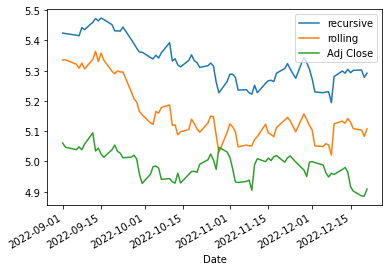


 forecasts 
             recursive   rolling
Date                           
2022-09-01   5.424430  5.335355
2022-09-02   5.422959  5.336118
2022-09-06   5.417527  5.321594
2022-09-07   5.415677  5.308319
2022-09-08   5.442553  5.325126
...               ...       ...
2022-12-15   5.293408  5.129615
2022-12-16   5.301072  5.108224
2022-12-19   5.302382  5.103947
2022-12-20   5.278092  5.082617
2022-12-21   5.291787  5.107570

[78 rows x 2 columns]

 MAE 
 recursive    2.669803
rolling      1.331938
dtype: float64

 RMSE 
 recursive    0.972026
rolling      0.518046
dtype: float64


In [19]:
#===================plot forecasts and calc error ===========================================================================    
    
forecasts = pd.concat(forecasts, axis=1)
obs = df.loc[df_test.index].apply(np.log)
# plot data and forcasts
output = pd.concat([forecasts, obs], axis=1)
output.plot()
plt.show()
# plot data and forcasts
epsilon = forecasts.sub(obs.squeeze(), axis=0)
    
mae = epsilon.abs().sum(axis=0)/10
rmse = ((epsilon**2).sum(axis=0)/10)**.5
    
print('\n forecasts \n', forecasts)
print('\n MAE \n', mae) 
print('\n RMSE \n', rmse) 

## VaR computations:

In [35]:
from scipy.stats import t
print(t.ppf(0.05,9.4548))
print(norm.ppf(0.05))

-1.8231245366836821
-1.6448536269514729


Iteration:      1,   Func. Count:      7,   Neg. LLF: 6988.224375263742
Iteration:      2,   Func. Count:     17,   Neg. LLF: 50688.60566980837
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2035.8088276138851
Iteration:      4,   Func. Count:     34,   Neg. LLF: 2907.448472559479
Iteration:      5,   Func. Count:     42,   Neg. LLF: 2613.0807163908876
Iteration:      6,   Func. Count:     49,   Neg. LLF: 1495.9852749960846
Iteration:      7,   Func. Count:     55,   Neg. LLF: 1495.9396291204237
Iteration:      8,   Func. Count:     61,   Neg. LLF: 1495.9326753514288
Iteration:      9,   Func. Count:     67,   Neg. LLF: 1495.9308521666105
Iteration:     10,   Func. Count:     73,   Neg. LLF: 1495.9306201237564
Iteration:     11,   Func. Count:     79,   Neg. LLF: 1495.9305506306682
Iteration:     12,   Func. Count:     85,   Neg. LLF: 1495.9305500117587
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1495.9305500117587
            Iterat

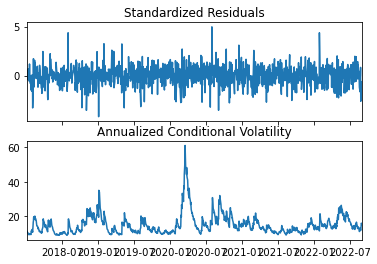

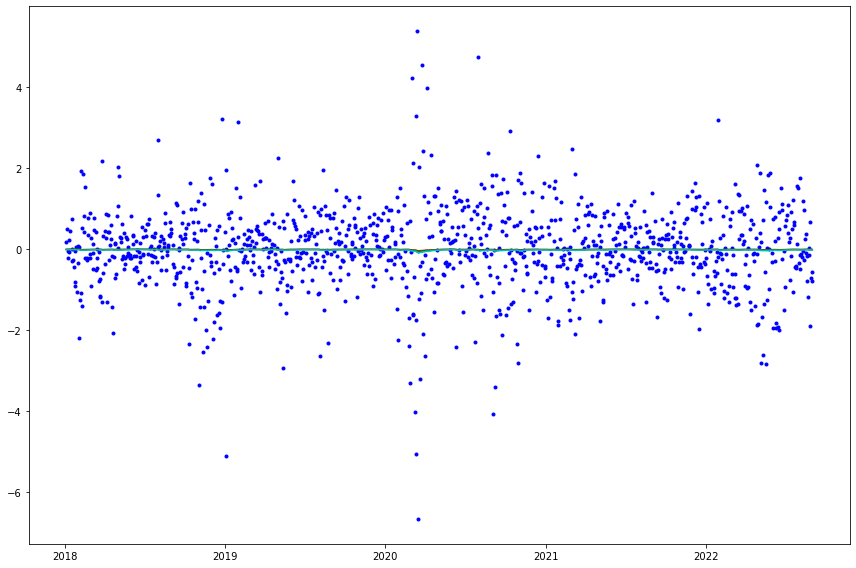

In [26]:
#================== In-sample Value-at-Risk estimates=================

#======= GARCH(1,1) estimates =====================================

arch = arch_model(df_train_std,p=1, o=0, q=1, mean='AR', lags=0, dist='t') 
res = arch.fit()
print(res.summary())
fig = res.plot(annualize='D')


temp = res.conditional_volatility
var90 = (0.0656 + res.conditional_volatility * t.ppf(0.10,9.2571)) /100
var95 = (0.0656 + res.conditional_volatility * t.ppf(0.05,9.2571)) /100
var99 = (0.0656 + res.conditional_volatility * t.ppf(0.01,9.2571)) /100
    
fig = plt.figure(figsize=(12,8))
plt.plot(df_train_std, 'b.', var90, 'r-', var95, 'g-', var99, 'c-')
plt.tight_layout()
 
print(np.mean(df_train_std < var90))  
print(np.mean(df_train_std < var95)) 
print(np.mean(df_train_std < var99))

**PAUL: Ok donc ici la vol dans les returns est vachement large, on voit à peine la diff entre les différentes VaR. Bon à analyser/commenter.** 

In [37]:
#============= Out-of-sample Value-at-Risk estimates ===========================
alpha = 0.01

oos = 78
nb_obs = len(df_logret)

VaR_oss = pd.DataFrame(index=range(0,nb_obs), columns=['VaR_sd','VaR_GARCH','VaR_GJR','VaR_GARCHstd'])

for x in range(nb_obs-oos, nb_obs):
    VaR_oss.iloc[x,VaR_oss.columns.get_loc("VaR_sd")] = np.std(df_test, axis=0) * norm.ppf(alpha) 
    arch_res = arch_model(df_test,p=1, o=0, q=0, dist='Normal').fit()
    arch_res_forecast = arch_res.forecast(horizon=1)
    VaR_oss.iloc[x,VaR_oss.columns.get_loc("VaR_GARCH")] = np.sqrt(arch_res_forecast.variance.values[-1, 0]) * norm.ppf(alpha)
    gjr_res = arch_model(df_test,p=1, o=1, q=1, dist='Normal').fit()
    gjr_res_forecast = arch_res.forecast(horizon=1)
    VaR_oss.iloc[x,VaR_oss.columns.get_loc("VaR_GJR")] = np.sqrt(gjr_res_forecast.variance.values[-1, 0]) * norm.ppf(alpha)
    garchSTD_res = arch_model(df_test,p=1, o=0, q=1, dist='t').fit()
    garchSTD_res_forecast = garchSTD_res.forecast(horizon=1)
    VaR_oss.iloc[x,VaR_oss.columns.get_loc("VaR_GARCHstd")] = np.sqrt(garchSTD_res_forecast.variance.values[-1, 0]) * t.ppf(alpha,garchSTD_res.params[-1])

Iteration:      1,   Func. Count:      5,   Neg. LLF: 236.4082906113731
Iteration:      2,   Func. Count:     11,   Neg. LLF: 205.87990749015196
Iteration:      3,   Func. Count:     16,   Neg. LLF: 184.2721159212002
Iteration:      4,   Func. Count:     21,   Neg. LLF: 178.76608788432077
Iteration:      5,   Func. Count:     25,   Neg. LLF: 178.63687413858645
Iteration:      6,   Func. Count:     29,   Neg. LLF: 178.61939848651443
Iteration:      7,   Func. Count:     33,   Neg. LLF: 178.61647622076447
Iteration:      8,   Func. Count:     37,   Neg. LLF: 178.6157952336772
Iteration:      9,   Func. Count:     41,   Neg. LLF: 178.61567172518704
Iteration:     10,   Func. Count:     44,   Neg. LLF: 178.61567172517564
Optimization terminated successfully    (Exit mode 0)
            Current function value: 178.61567172518704
            Iterations: 10
            Function evaluations: 44
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      7,   Neg. LLF: 215.31081

Iteration:      1,   Func. Count:      7,   Neg. LLF: 215.31081011053013
Iteration:      2,   Func. Count:     14,   Neg. LLF: 186.29820528807113
Iteration:      3,   Func. Count:     21,   Neg. LLF: 178.63856893662424
Iteration:      4,   Func. Count:     28,   Neg. LLF: 176.3671757178784
Iteration:      5,   Func. Count:     34,   Neg. LLF: 176.7247211411713
Iteration:      6,   Func. Count:     41,   Neg. LLF: 176.28939597939865
Iteration:      7,   Func. Count:     47,   Neg. LLF: 176.26886099423973
Iteration:      8,   Func. Count:     53,   Neg. LLF: 176.26772864757964
Iteration:      9,   Func. Count:     59,   Neg. LLF: 176.2676732124162
Iteration:     10,   Func. Count:     64,   Neg. LLF: 176.26767340466608
Optimization terminated successfully    (Exit mode 0)
            Current function value: 176.2676732124162
            Iterations: 10
            Function evaluations: 64
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      7,   Neg. LLF: 185.811799

Iteration:     24,   Func. Count:    147,   Neg. LLF: 178.59948345309212
Iteration:     25,   Func. Count:    154,   Neg. LLF: 178.5991647342541
Iteration:     26,   Func. Count:    160,   Neg. LLF: 178.59915427124233
Iteration:     27,   Func. Count:    166,   Neg. LLF: 178.59915427219104
Iteration:     28,   Func. Count:    173,   Neg. LLF: 178.5991529315816
Optimization terminated successfully    (Exit mode 0)
            Current function value: 178.5991523753546
            Iterations: 28
            Function evaluations: 183
            Gradient evaluations: 28
Iteration:      1,   Func. Count:      5,   Neg. LLF: 236.4082906113731
Iteration:      2,   Func. Count:     11,   Neg. LLF: 205.87990749015196
Iteration:      3,   Func. Count:     16,   Neg. LLF: 184.2721159212002
Iteration:      4,   Func. Count:     21,   Neg. LLF: 178.76608788432077
Iteration:      5,   Func. Count:     25,   Neg. LLF: 178.63687413858645
Iteration:      6,   Func. Count:     29,   Neg. LLF: 178.619398

Iteration:      1,   Func. Count:      7,   Neg. LLF: 185.8117996869752
Iteration:      2,   Func. Count:     14,   Neg. LLF: 179.19295475619512
Iteration:      3,   Func. Count:     20,   Neg. LLF: 180.43183229906728
Iteration:      4,   Func. Count:     27,   Neg. LLF: 178.98127072338082
Iteration:      5,   Func. Count:     33,   Neg. LLF: 178.88587189507672
Iteration:      6,   Func. Count:     39,   Neg. LLF: 178.8180822958301
Iteration:      7,   Func. Count:     45,   Neg. LLF: 178.75169194892257
Iteration:      8,   Func. Count:     51,   Neg. LLF: 178.72830207823083
Iteration:      9,   Func. Count:     57,   Neg. LLF: 178.71837174254603
Iteration:     10,   Func. Count:     63,   Neg. LLF: 178.7132747316166
Iteration:     11,   Func. Count:     69,   Neg. LLF: 178.71131064166042
Iteration:     12,   Func. Count:     75,   Neg. LLF: 178.70090234242502
Iteration:     13,   Func. Count:     81,   Neg. LLF: 178.6850171622467
Iteration:     14,   Func. Count:     87,   Neg. LLF: 1

Iteration:      3,   Func. Count:     16,   Neg. LLF: 184.2721159212002
Iteration:      4,   Func. Count:     21,   Neg. LLF: 178.76608788432077
Iteration:      5,   Func. Count:     25,   Neg. LLF: 178.63687413858645
Iteration:      6,   Func. Count:     29,   Neg. LLF: 178.61939848651443
Iteration:      7,   Func. Count:     33,   Neg. LLF: 178.61647622076447
Iteration:      8,   Func. Count:     37,   Neg. LLF: 178.6157952336772
Iteration:      9,   Func. Count:     41,   Neg. LLF: 178.61567172518704
Iteration:     10,   Func. Count:     44,   Neg. LLF: 178.61567172517564
Optimization terminated successfully    (Exit mode 0)
            Current function value: 178.61567172518704
            Iterations: 10
            Function evaluations: 44
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      7,   Neg. LLF: 215.31081011053013
Iteration:      2,   Func. Count:     14,   Neg. LLF: 186.29820528807113
Iteration:      3,   Func. Count:     21,   Neg. LLF: 178.6385

Iteration:     15,   Func. Count:     93,   Neg. LLF: 178.62658881352712
Iteration:     16,   Func. Count:     99,   Neg. LLF: 178.61456122770795
Iteration:     17,   Func. Count:    105,   Neg. LLF: 178.60952654087873
Iteration:     18,   Func. Count:    111,   Neg. LLF: 178.60525095128804
Iteration:     19,   Func. Count:    117,   Neg. LLF: 178.60188029271825
Iteration:     20,   Func. Count:    123,   Neg. LLF: 178.59994142807346
Iteration:     21,   Func. Count:    129,   Neg. LLF: 178.5993906022953
Iteration:     22,   Func. Count:    135,   Neg. LLF: 178.5992600894104
Iteration:     23,   Func. Count:    141,   Neg. LLF: 178.59920328087838
Iteration:     24,   Func. Count:    147,   Neg. LLF: 178.59948345309212
Iteration:     25,   Func. Count:    154,   Neg. LLF: 178.5991647342541
Iteration:     26,   Func. Count:    160,   Neg. LLF: 178.59915427124233
Iteration:     27,   Func. Count:    166,   Neg. LLF: 178.59915427219104
Iteration:     28,   Func. Count:    173,   Neg. LLF: 

Iteration:      1,   Func. Count:      7,   Neg. LLF: 185.8117996869752
Iteration:      2,   Func. Count:     14,   Neg. LLF: 179.19295475619512
Iteration:      3,   Func. Count:     20,   Neg. LLF: 180.43183229906728
Iteration:      4,   Func. Count:     27,   Neg. LLF: 178.98127072338082
Iteration:      5,   Func. Count:     33,   Neg. LLF: 178.88587189507672
Iteration:      6,   Func. Count:     39,   Neg. LLF: 178.8180822958301
Iteration:      7,   Func. Count:     45,   Neg. LLF: 178.75169194892257
Iteration:      8,   Func. Count:     51,   Neg. LLF: 178.72830207823083
Iteration:      9,   Func. Count:     57,   Neg. LLF: 178.71837174254603
Iteration:     10,   Func. Count:     63,   Neg. LLF: 178.7132747316166
Iteration:     11,   Func. Count:     69,   Neg. LLF: 178.71131064166042
Iteration:     12,   Func. Count:     75,   Neg. LLF: 178.70090234242502
Iteration:     13,   Func. Count:     81,   Neg. LLF: 178.6850171622467
Iteration:     14,   Func. Count:     87,   Neg. LLF: 1

Iteration:      8,   Func. Count:     37,   Neg. LLF: 178.6157952336772
Iteration:      9,   Func. Count:     41,   Neg. LLF: 178.61567172518704
Iteration:     10,   Func. Count:     44,   Neg. LLF: 178.61567172517564
Optimization terminated successfully    (Exit mode 0)
            Current function value: 178.61567172518704
            Iterations: 10
            Function evaluations: 44
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      7,   Neg. LLF: 215.31081011053013
Iteration:      2,   Func. Count:     14,   Neg. LLF: 186.29820528807113
Iteration:      3,   Func. Count:     21,   Neg. LLF: 178.63856893662424
Iteration:      4,   Func. Count:     28,   Neg. LLF: 176.3671757178784
Iteration:      5,   Func. Count:     34,   Neg. LLF: 176.7247211411713
Iteration:      6,   Func. Count:     41,   Neg. LLF: 176.28939597939865
Iteration:      7,   Func. Count:     47,   Neg. LLF: 176.26886099423973
Iteration:      8,   Func. Count:     53,   Neg. LLF: 176.26772

Iteration:     18,   Func. Count:    111,   Neg. LLF: 178.60525095128804
Iteration:     19,   Func. Count:    117,   Neg. LLF: 178.60188029271825
Iteration:     20,   Func. Count:    123,   Neg. LLF: 178.59994142807346
Iteration:     21,   Func. Count:    129,   Neg. LLF: 178.5993906022953
Iteration:     22,   Func. Count:    135,   Neg. LLF: 178.5992600894104
Iteration:     23,   Func. Count:    141,   Neg. LLF: 178.59920328087838
Iteration:     24,   Func. Count:    147,   Neg. LLF: 178.59948345309212
Iteration:     25,   Func. Count:    154,   Neg. LLF: 178.5991647342541
Iteration:     26,   Func. Count:    160,   Neg. LLF: 178.59915427124233
Iteration:     27,   Func. Count:    166,   Neg. LLF: 178.59915427219104
Iteration:     28,   Func. Count:    173,   Neg. LLF: 178.5991529315816
Optimization terminated successfully    (Exit mode 0)
            Current function value: 178.5991523753546
            Iterations: 28
            Function evaluations: 183
            Gradient evaluat

Iteration:      2,   Func. Count:     14,   Neg. LLF: 179.19295475619512
Iteration:      3,   Func. Count:     20,   Neg. LLF: 180.43183229906728
Iteration:      4,   Func. Count:     27,   Neg. LLF: 178.98127072338082
Iteration:      5,   Func. Count:     33,   Neg. LLF: 178.88587189507672
Iteration:      6,   Func. Count:     39,   Neg. LLF: 178.8180822958301
Iteration:      7,   Func. Count:     45,   Neg. LLF: 178.75169194892257
Iteration:      8,   Func. Count:     51,   Neg. LLF: 178.72830207823083
Iteration:      9,   Func. Count:     57,   Neg. LLF: 178.71837174254603
Iteration:     10,   Func. Count:     63,   Neg. LLF: 178.7132747316166
Iteration:     11,   Func. Count:     69,   Neg. LLF: 178.71131064166042
Iteration:     12,   Func. Count:     75,   Neg. LLF: 178.70090234242502
Iteration:     13,   Func. Count:     81,   Neg. LLF: 178.6850171622467
Iteration:     14,   Func. Count:     87,   Neg. LLF: 178.6550955997346
Iteration:     15,   Func. Count:     93,   Neg. LLF: 1

Iteration:      2,   Func. Count:     14,   Neg. LLF: 186.29820528807113
Iteration:      3,   Func. Count:     21,   Neg. LLF: 178.63856893662424
Iteration:      4,   Func. Count:     28,   Neg. LLF: 176.3671757178784
Iteration:      5,   Func. Count:     34,   Neg. LLF: 176.7247211411713
Iteration:      6,   Func. Count:     41,   Neg. LLF: 176.28939597939865
Iteration:      7,   Func. Count:     47,   Neg. LLF: 176.26886099423973
Iteration:      8,   Func. Count:     53,   Neg. LLF: 176.26772864757964
Iteration:      9,   Func. Count:     59,   Neg. LLF: 176.2676732124162
Iteration:     10,   Func. Count:     64,   Neg. LLF: 176.26767340466608
Optimization terminated successfully    (Exit mode 0)
            Current function value: 176.2676732124162
            Iterations: 10
            Function evaluations: 64
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      7,   Neg. LLF: 185.8117996869752
Iteration:      2,   Func. Count:     14,   Neg. LLF: 179.1929547

Iteration:     28,   Func. Count:    173,   Neg. LLF: 178.5991529315816
Optimization terminated successfully    (Exit mode 0)
            Current function value: 178.5991523753546
            Iterations: 28
            Function evaluations: 183
            Gradient evaluations: 28
Iteration:      1,   Func. Count:      5,   Neg. LLF: 236.4082906113731
Iteration:      2,   Func. Count:     11,   Neg. LLF: 205.87990749015196
Iteration:      3,   Func. Count:     16,   Neg. LLF: 184.2721159212002
Iteration:      4,   Func. Count:     21,   Neg. LLF: 178.76608788432077
Iteration:      5,   Func. Count:     25,   Neg. LLF: 178.63687413858645
Iteration:      6,   Func. Count:     29,   Neg. LLF: 178.61939848651443
Iteration:      7,   Func. Count:     33,   Neg. LLF: 178.61647622076447
Iteration:      8,   Func. Count:     37,   Neg. LLF: 178.6157952336772
Iteration:      9,   Func. Count:     41,   Neg. LLF: 178.61567172518704
Iteration:     10,   Func. Count:     44,   Neg. LLF: 178.615671

Iteration:     19,   Func. Count:    117,   Neg. LLF: 178.60188029271825
Iteration:     20,   Func. Count:    123,   Neg. LLF: 178.59994142807346
Iteration:     21,   Func. Count:    129,   Neg. LLF: 178.5993906022953
Iteration:     22,   Func. Count:    135,   Neg. LLF: 178.5992600894104
Iteration:     23,   Func. Count:    141,   Neg. LLF: 178.59920328087838
Iteration:     24,   Func. Count:    147,   Neg. LLF: 178.59948345309212
Iteration:     25,   Func. Count:    154,   Neg. LLF: 178.5991647342541
Iteration:     26,   Func. Count:    160,   Neg. LLF: 178.59915427124233
Iteration:     27,   Func. Count:    166,   Neg. LLF: 178.59915427219104
Iteration:     28,   Func. Count:    173,   Neg. LLF: 178.5991529315816
Optimization terminated successfully    (Exit mode 0)
            Current function value: 178.5991523753546
            Iterations: 28
            Function evaluations: 183
            Gradient evaluations: 28
Iteration:      1,   Func. Count:      5,   Neg. LLF: 236.408290

Iteration:      5,   Func. Count:     33,   Neg. LLF: 178.88587189507672
Iteration:      6,   Func. Count:     39,   Neg. LLF: 178.8180822958301
Iteration:      7,   Func. Count:     45,   Neg. LLF: 178.75169194892257
Iteration:      8,   Func. Count:     51,   Neg. LLF: 178.72830207823083
Iteration:      9,   Func. Count:     57,   Neg. LLF: 178.71837174254603
Iteration:     10,   Func. Count:     63,   Neg. LLF: 178.7132747316166
Iteration:     11,   Func. Count:     69,   Neg. LLF: 178.71131064166042
Iteration:     12,   Func. Count:     75,   Neg. LLF: 178.70090234242502
Iteration:     13,   Func. Count:     81,   Neg. LLF: 178.6850171622467
Iteration:     14,   Func. Count:     87,   Neg. LLF: 178.6550955997346
Iteration:     15,   Func. Count:     93,   Neg. LLF: 178.62658881352712
Iteration:     16,   Func. Count:     99,   Neg. LLF: 178.61456122770795
Iteration:     17,   Func. Count:    105,   Neg. LLF: 178.60952654087873
Iteration:     18,   Func. Count:    111,   Neg. LLF: 1

Iteration:      1,   Func. Count:      7,   Neg. LLF: 215.31081011053013
Iteration:      2,   Func. Count:     14,   Neg. LLF: 186.29820528807113
Iteration:      3,   Func. Count:     21,   Neg. LLF: 178.63856893662424
Iteration:      4,   Func. Count:     28,   Neg. LLF: 176.3671757178784
Iteration:      5,   Func. Count:     34,   Neg. LLF: 176.7247211411713
Iteration:      6,   Func. Count:     41,   Neg. LLF: 176.28939597939865
Iteration:      7,   Func. Count:     47,   Neg. LLF: 176.26886099423973
Iteration:      8,   Func. Count:     53,   Neg. LLF: 176.26772864757964
Iteration:      9,   Func. Count:     59,   Neg. LLF: 176.2676732124162
Iteration:     10,   Func. Count:     64,   Neg. LLF: 176.26767340466608
Optimization terminated successfully    (Exit mode 0)
            Current function value: 176.2676732124162
            Iterations: 10
            Function evaluations: 64
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      7,   Neg. LLF: 185.811799

Iteration:     27,   Func. Count:    166,   Neg. LLF: 178.59915427219104
Iteration:     28,   Func. Count:    173,   Neg. LLF: 178.5991529315816
Optimization terminated successfully    (Exit mode 0)
            Current function value: 178.5991523753546
            Iterations: 28
            Function evaluations: 183
            Gradient evaluations: 28
Iteration:      1,   Func. Count:      5,   Neg. LLF: 236.4082906113731
Iteration:      2,   Func. Count:     11,   Neg. LLF: 205.87990749015196
Iteration:      3,   Func. Count:     16,   Neg. LLF: 184.2721159212002
Iteration:      4,   Func. Count:     21,   Neg. LLF: 178.76608788432077
Iteration:      5,   Func. Count:     25,   Neg. LLF: 178.63687413858645
Iteration:      6,   Func. Count:     29,   Neg. LLF: 178.61939848651443
Iteration:      7,   Func. Count:     33,   Neg. LLF: 178.61647622076447
Iteration:      8,   Func. Count:     37,   Neg. LLF: 178.6157952336772
Iteration:      9,   Func. Count:     41,   Neg. LLF: 178.615671

Iteration:     14,   Func. Count:     87,   Neg. LLF: 178.6550955997346
Iteration:     15,   Func. Count:     93,   Neg. LLF: 178.62658881352712
Iteration:     16,   Func. Count:     99,   Neg. LLF: 178.61456122770795
Iteration:     17,   Func. Count:    105,   Neg. LLF: 178.60952654087873
Iteration:     18,   Func. Count:    111,   Neg. LLF: 178.60525095128804
Iteration:     19,   Func. Count:    117,   Neg. LLF: 178.60188029271825
Iteration:     20,   Func. Count:    123,   Neg. LLF: 178.59994142807346
Iteration:     21,   Func. Count:    129,   Neg. LLF: 178.5993906022953
Iteration:     22,   Func. Count:    135,   Neg. LLF: 178.5992600894104
Iteration:     23,   Func. Count:    141,   Neg. LLF: 178.59920328087838
Iteration:     24,   Func. Count:    147,   Neg. LLF: 178.59948345309212
Iteration:     25,   Func. Count:    154,   Neg. LLF: 178.5991647342541
Iteration:     26,   Func. Count:    160,   Neg. LLF: 178.59915427124233
Iteration:     27,   Func. Count:    166,   Neg. LLF: 1

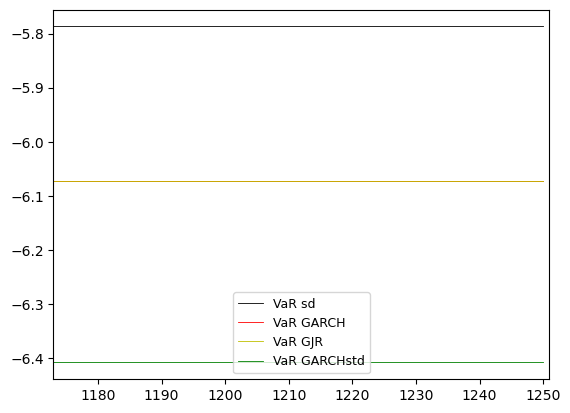

In [41]:
plt.clf()
plt.plot(VaR_oss['VaR_sd'], 'k', label='VaR sd',linewidth=0.6)
plt.plot(VaR_oss['VaR_GARCH'], 'r', label='VaR GARCH',linewidth=0.6)
plt.plot(VaR_oss['VaR_GJR'], 'y', label='VaR GJR',linewidth=0.6)
plt.plot(VaR_oss['VaR_GARCHstd'], 'g', label='VaR GARCHstd',linewidth=0.6)
plt.xlim(nb_obs-oos, nb_obs)
plt.legend(loc='best', fontsize=9)